# Final Project Group 5 - **Model Predict User**



---
# II. Import Libraries


In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Metric
from sklearn.metrics import classification_report

# Model Saving
import pickle

# code untuk menghilangkan warning
from warnings import filterwarnings
filterwarnings('ignore')

---
# III. Data Loading

In [2]:
# load dataset
df = pd.read_csv('Data\df_travel_V2.csv')

In [3]:
# opsi pada pandas untuk melihat kolom data secara keseluruhan
pd.options.display.max_columns = None

In [4]:
# konversi rupee ke rupiah
df['MonthlyIncome_rp'] = df['MonthlyIncome'] * 189.68

In [5]:
# membuat fungsi untuk distribusi data menggunakan histogram dan boxplot
def plot_dist(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print('Skewness :', df[col].skew())
    if -0.5 <= df[col].skew() <= 0.5:
        print("Kolom '{}' berdistribusi normal".format(col))
    elif df[col].skew() > 0.5:
        print("Kolom '{}' right skewed (miring ke kanan)".format(col))
    elif df[col].skew() < -0.5:
        print("Kolom '{}' left skewed (miring ke kiri)".format(col))

---
# V. Data Preprocessing

## Split Data Inference

Untuk melakukan model inference, kita akan memisahkan 20 data sampel dari dataset awal yang selanjutnya akan disimpan dalam variabel baru bernama `df_inf`.

In [6]:
# split data inference dari dataset awal
df_inf = df.sample(20, random_state = 50)
df_inf

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,MonthlyIncome_rp
3216,203216,Not_taken,57.0,Company Invited,1,16.0,Small Business,Female,4,4.0,Basic,3.0,Divorced,4.0,0,2,0,1.0,Executive,21620.0,4100881.60
3961,203961,Not_taken,38.0,Self Enquiry,1,26.0,Salaried,Male,4,4.0,Basic,4.0,Married,6.0,0,4,0,2.0,Executive,21700.0,4116056.00
1750,201750,Not_taken,53.0,Self Enquiry,1,9.0,Small Business,Male,2,3.0,Super Deluxe,3.0,Married,4.0,1,5,1,0.0,AVP,32584.0,6180533.12
2979,202979,Not_taken,42.0,Self Enquiry,2,17.0,Salaried,Male,4,5.0,King,3.0,Married,0.0,0,2,1,1.0,VP,37819.0,7173507.92
2727,202727,Not_taken,56.0,Self Enquiry,1,27.0,Large Business,Male,3,4.0,Deluxe,3.0,Divorced,5.0,1,2,1,2.0,Manager,24093.0,4569960.24
2136,202136,Taken,45.0,Self Enquiry,1,9.0,Salaried,Female,2,3.0,Deluxe,3.0,Married,1.0,1,5,1,1.0,Manager,35421.0,6718655.28
2766,202766,Not_taken,33.0,Self Enquiry,1,9.0,Small Business,Female,4,3.0,Deluxe,3.0,Unmarried,2.0,0,3,1,3.0,Manager,23733.0,4501675.44
4143,204143,Taken,30.0,Self Enquiry,1,25.0,Small Business,Male,3,5.0,Basic,3.0,Single,3.0,1,3,0,1.0,Executive,21067.0,3995988.56
977,200977,Not_taken,34.0,Company Invited,1,32.0,Large Business,Female,3,4.0,Basic,3.0,Married,2.0,0,1,1,0.0,Executive,17029.0,3230060.72
608,200608,Taken,55.0,Self Enquiry,3,8.0,Small Business,Male,2,3.0,Deluxe,3.0,Single,5.0,0,2,0,1.0,Manager,20160.0,3823948.80


In [7]:
# cek proporsi label pada data inference
df_inf['ProductPitched'].value_counts()

Basic           8
Deluxe          8
Super Deluxe    2
King            2
Name: ProductPitched, dtype: int64

Proporsi label `ProductPitched` pada data inference adalah 8 user dengan kelas 'Basic', 8 user dengan kelas 'Deluxe', 2 user dengan kelas 'Super Deluxe', dan 2 user dengan kelas 'King'. Proporsi label ini sudah cukup baik untuk dapat dijadikan sebagai data inference.

Data inference yang sudah dipisahkan lalu didrop index datanya pada dataset untuk training model agar model tidak mengalami kebocoran data karena model telah mempelajari data inference tersebut terlebih dahulu.

In [8]:
# drop index data inference pada data untuk train-val-test set
df_train_test = df.drop(df_inf.index)

Selanjutnya kita akan melakukan reset index agar penomoran data kembali sesuai urutannya pada masing-masing variabel dataset.

In [9]:
# reset index
df_train_test.reset_index(drop = True, inplace = True)
df_inf.reset_index(drop = True, inplace = True)

## Split Label (y) dan Fitur (X)

Label adalah variabel yang ingin diprediksi, yaitu kolom `ProductPitched`. Fitur adalah kolom-kolom yang akan dijadikan sebagai variabel penentu dalam memprediksi label. Kita akan melakukan features selection bagian 1 diawal dengan asumsi bahwa kita tidak memerlukan fitur tersebut dalam menentukan kolom label `ProductPitched`. Seperti yang kita ketahui diawal, dataset ini berfokus pada penawaran paket liburan kepada user, maka dari itu kita akan merubah fokus kita dengan berfokus pada klasifikasi user tersebut, sehingga konteks-konteks yang berhubungan dengan penawaran paket liburan ini akan kita drop. Berikut adalah fitur-fitur yang akan didrop beserta alasannya:
1. `CustomerID` : Fitur ini hanya berisikan kode unik user, tidak diperlukan dalam membuat model
2. `ProdTaken` : Fitur ini berisi nilai biner apakah paket liburan diambil atau tidak diambil oleh user, dalam hal ini asumsi kita adalah seluruh user mengambil paket liburan yang ditawarkan kepadanya, sehingga kita dapat melakukan drop pada fitur ini.
3. `TypeOfContact` : Fitur ini berisikan mengenai cara sales untuk menghubungi user dengan tujuan menawarkan paket liburan. Karena fitur ini berhubungan pada konteks penawaran paket liburan, maka fitur ini dapat kita drop.
4. `NumberOfFollowups` : Fitur ini berisikan jumlah follow up dari sales kepada user. Karena fitur ini berhubungan dengan penawaran paket liburan, maka akan kita drop fitur ini.
5. `DurationPitch` : Fitur ini berisikan durasi sales menawarkan produk paket liburan kepada user. Karena fitur ini berhubungan dengan penawaran paket liburan, maka akan kita drop fitur ini.
6. `MonthlyIncome` : Fitur ini berisikan pendapatan perbulan user dengan satuan rupee India. Karena kita telah memiliki fitur pendapatan perbulan user dengan satuan rupiah Indonesia (`MonthlyIncome_rp`), maka kita dapat melakukan drop pada fitur ini.

Berdasarkan hasil EDA sebelumnya, kita telah mengetahui bahwa kelas pada kolom `ProductPitched` dapat kita kerucutkan menjadi 3 kelas saja, yaitu Basic, Deluxe, dan King dengan ketentuan sebagai berikut:
- Basic : 0 (Paket Basic)
- Deluxe, Standard : 1 (Paket Deluxe)
- Super Deluxe, King : 2 (Paket King)

In [10]:
# unique value kolom label sebelum dikonversi menjadi 3 kelas
df_train_test['ProductPitched'].value_counts()

Basic           1834
Deluxe          1724
Standard         742
Super Deluxe     340
King             228
Name: ProductPitched, dtype: int64

In [11]:
# split label dan fitur
X = df_train_test.drop(['CustomerID', 'ProductPitched', 'ProdTaken', 'TypeofContact','NumberOfFollowups', 'DurationOfPitch', 'MonthlyIncome'], axis = 1)
y = df_train_test['ProductPitched'].map({'Basic': 0, 'Deluxe': 1, 'Standard': 1, 'Super Deluxe': 2, 'King' : 2})

In [12]:
# ukuran dimensi fitur dan label
print('Ukuran dimensi fitur: ', X.shape)
print('Ukuran dimensi label: ', y.shape)

Ukuran dimensi fitur:  (4868, 14)
Ukuran dimensi label:  (4868,)


Terdapat 4.868 baris data dengan 14 fitur yang akan kita jadikan sebagai dataset train-test.

In [13]:
# unique value kolom label setelah dikonversi menjadi 3 kelas
y.value_counts()

1    2466
0    1834
2     568
Name: ProductPitched, dtype: int64

Kolom label telah kita kerucutkan menjadi 3 kelas (Basic, Deluxe, King).

## List Data Numerik dan Kategorik

Untuk melakukan scaling dan encoding data, kita perlu mendefinisikan kolom apa saja yang termasuk kolom bertipe numerik dan kolom bertipe kategorik. Kolom bertipe kategorik akan dibagi menjadi 2 jenis, yaitu kolom kategorik nominal, dan kolom kategorik ordinal. Kolom kategorik nominal adalah kolom kategorik yang tidak memiliki tingkatan / ordinal pada setiap valuenya, sehingga kolom kategorik nominal ini akan kita encoding menggunakan One Hot Encoder. Sedangkan kolom kategorik ordinal merupakan kolom kategorik yang valuenya memiliki tingkatan / ordinal. Kolom kategorik ordinal akan kita encoding menggunakan Ordinal Encoder.

In [14]:
# list data kategorik dan numerik
cat_cols = ['CityTier', 'Occupation', 'Gender', 'MaritalStatus', 'Passport', 'OwnCar', 'Designation']
cat_cols_ord = ['PreferredPropertyStar', 'PitchSatisfactionScore']
num_cols = ['Age', 'NumberOfPersonVisiting', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'MonthlyIncome_rp']

In [15]:
# looping untuk melihat value data kategorik ordinal
for i in (cat_cols_ord): 
    print(f'Unique kolom {i} :', X[i].unique())

Unique kolom PreferredPropertyStar : [3. 4. 5.]
Unique kolom PitchSatisfactionScore : [2 3 5 4 1]


In [16]:
# looping untuk melihat value data kategorik nominal
for i in (cat_cols): 
    print(f'Unique kolom {i} :', X[i].unique())

Unique kolom CityTier : [3 1 2]
Unique kolom Occupation : ['Salaried' 'Free Lancer' 'Small Business' 'Large Business']
Unique kolom Gender : ['Female' 'Male']
Unique kolom MaritalStatus : ['Single' 'Divorced' 'Married' 'Unmarried']
Unique kolom Passport : [1 0]
Unique kolom OwnCar : [1 0]
Unique kolom Designation : ['Manager' 'Executive' 'Senior Manager' 'AVP' 'VP']


Value kategori 'Unmarried' dan 'Single' pada kolom `MaritalStatus` dapat digabungkan menjadi satu value karena terdapat kesamaan value, maka dari itu value 'Unmarried' akan dikonversikan menjadi value 'Single'.

Hasil EDA juga memperlihatkan bahwa value kategori 'Free Lancer' pada kolom `Designation` hanya dimiliki oleh 2 user saja dari total 4.868 data user. Untuk mengurangi resiko error pada saat proses modeling, maka kelas 'Free Lancer' ini akan dikonversikan menjadi kelas 'Salaried'.

In [17]:
# menggabungkan beberapa value kategori
X['MaritalStatus'] = X['MaritalStatus'].replace('Unmarried', 'Single')
X['Occupation'] = X['Occupation'].replace('Free Lancer', 'Salaried')

In [18]:
# melihat hasil penggabungan value pada kolom `MaritalStatus`
X['MaritalStatus'].value_counts()

Married     2331
Single      1590
Divorced     947
Name: MaritalStatus, dtype: int64

In [19]:
# melihat hasil penggabungan value pada kolom `Occupation`
X['Occupation'].value_counts()

Salaried          2361
Small Business    2075
Large Business     432
Name: Occupation, dtype: int64

## Split Data Train-set dan Test-set

Splitting data menjadi data train-set dan data test-set dengan perbandingan 80% data train-set, dan 20% data test-set.

In [20]:
# split data trainval-set dan test-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

print('Ukuran dimensi Data Train-set: ', X_train.shape)
print('Ukuran dimensi Data Test-set: ', X_test.shape)

Ukuran dimensi Data Train-set:  (3894, 14)
Ukuran dimensi Data Test-set:  (974, 14)


In [21]:
# Cek proporsi label pada data train-set dan test-set
print('Proporsi label pada Data Train-set: \n', y_train.value_counts())
print('Proporsi label pada Data Test-set: \n', y_test.value_counts())

Proporsi label pada Data Train-set: 
 1    1960
0    1475
2     459
Name: ProductPitched, dtype: int64
Proporsi label pada Data Test-set: 
 1    506
0    359
2    109
Name: ProductPitched, dtype: int64


Proporsi label pada train-set dan test-set sudah cukup baik.

## Handling Outliers pada Data Train-set

Hasil EDA menunjukan bahwa terdapat beberapa kolom numerik yang memiliki outlier. Hal ini perlu kita tangani terlebih dahulu karena terdapat beberapa model yang sensitif terhadap data outlier. Metode handling outlier yang akan kita gunakan adalah metode capping dengan menggunakan library Winsorizer. Metode capping yang digunakan adalah IQR dengan batas pada kiri dan kanan (both) dengan fold sebesar 1.5

In [22]:
# buat batas outlier menggunakan winsorizer
winsorizer = Winsorizer(capping_method='iqr',
                         tail='both',
                         fold=1.5,
                         variables=num_cols
                         )

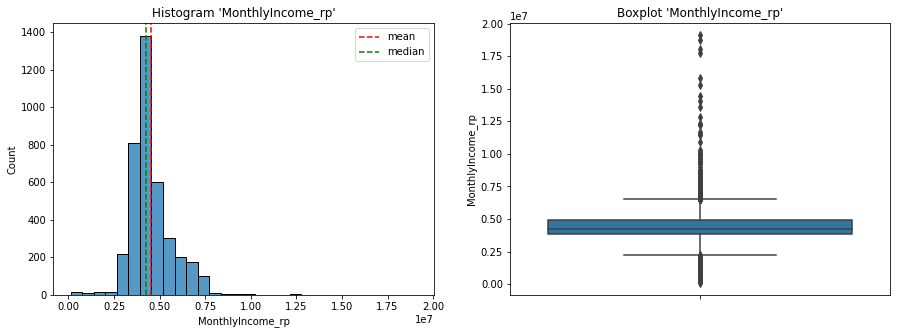

Skewness : 2.710108298291917
Kolom 'MonthlyIncome_rp' right skewed (miring ke kanan)


In [23]:
# sebelum handling outlier
plot_dist(X_train, 'MonthlyIncome_rp')

In [24]:
# fit dan transform metode handling outlier pada data train-set
X_train = winsorizer.fit_transform(X_train)

# transform metode handling outlier pada data test-set
X_test = winsorizer.transform(X_test)

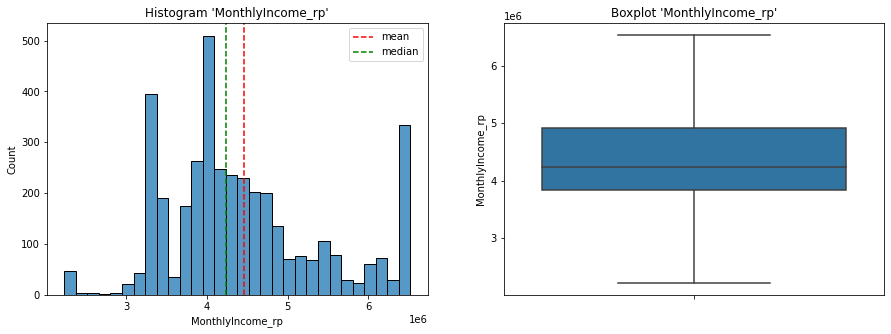

Skewness : 0.6379695986962151
Kolom 'MonthlyIncome_rp' right skewed (miring ke kanan)


In [25]:
# setelah handling outlier
plot_dist(X_train, 'MonthlyIncome_rp')

Setelah kita melakukan handling outlier, terlihat bahwa sekarang kolom numerik sudah tidak memiliki outlier.

## Data Scaling dan Encoding 

Seperti yang sudah disinggung sebelumnya, metode encoding yang kita pilih adalah One Hot Encoder pada kolom kategorik nominal, dan Ordinal Encoder pada kolom kategorik ordinal. Untuk kolom numerik, kita akan melakukan scaling dengan menggunakan Robust Scaler karena terdapat beberapa kolom numerik yang memiliki distribusi data tidak normal. Metode scaling dan encoding ini akan digabungkan dalam satu pipeline agar prosesnya menjadi lebih ringkas.

In [26]:
# Scaler dan Encoder
scaler = RobustScaler()
ohe = OneHotEncoder()
ord = OrdinalEncoder()

# Pipeline
pipeline_pre = ColumnTransformer([('scaler', scaler, num_cols),
                            ('ohe', ohe, cat_cols),
                            ('ordinal_encoder', ord, cat_cols_ord)],
                            remainder='passthrough')

In [27]:
# fit dan transform pipeline pada train-set
X_train_final = pipeline_pre.fit_transform(X_train)

# transform pipeline pada data test-set
X_test_final = pipeline_pre.transform(X_test)

In [28]:
# features name hasil one hot encoder
ohe_features = pipeline_pre.named_transformers_['ohe'].get_feature_names().tolist()
ohe_features

['x0_1',
 'x0_2',
 'x0_3',
 'x1_Large Business',
 'x1_Salaried',
 'x1_Small Business',
 'x2_Female',
 'x2_Male',
 'x3_Divorced',
 'x3_Married',
 'x3_Single',
 'x4_0',
 'x4_1',
 'x5_0',
 'x5_1',
 'x6_AVP',
 'x6_Executive',
 'x6_Manager',
 'x6_Senior Manager',
 'x6_VP']

Hasil coding diatas merupakan nama-nama kolom / fitur yang merupakan hasil dari One Hot Encoder yang selanjutnya kita simpan dalam variabel `ohe_features`.

In [29]:
# convert ke dataframe
X_train_final_df = pd.DataFrame(X_train_final, columns = num_cols + ohe_features + cat_cols_ord)
X_train_final_df.head(10)

,Age,NumberOfPersonVisiting,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome_rp,x0_1,x0_2,x0_3,x1_Large Business,x1_Salaried,x1_Small Business,x2_Female,x2_Male,x3_Divorced,x3_Married,x3_Single,x4_0,x4_1,x5_0,x5_1,x6_AVP,x6_Executive,x6_Manager,x6_Senior Manager,x6_VP,PreferredPropertyStar,PitchSatisfactionScore
0,-0.076923,0.0,0.0,1.0,0.058350,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.846154,0.0,-0.5,0.0,0.701264,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
2,0.384615,-1.0,0.0,0.0,-1.629211,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0
3,-0.615385,0.0,0.0,0.0,-0.142870,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.0,0.0,0.0,-0.046680,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
5,-0.384615,1.0,0.0,2.0,0.372027,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
6,-0.769231,-1.0,2.0,0.0,-0.357705,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0
7,-0.153846,1.0,0.0,0.0,-0.057113,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0
8,1.000000,1.0,0.5,0.0,0.100610,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,0.769231,1.0,0.0,1.0,0.666608,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0


Tabel diatas merupakan hasil dari scaling dan encoding data train-set.

---

# Features Selection - Features Importance (Random Forest)

Pada proses features selection bagian 2 ini, kita akan melakukan seleksi fitur-fitur apa saja yang akan kita gunakan untuk modeling dengan melakukan analisis pada features importance yang dimiliki oleh model random forest. Model random forest akan kita fit pada train-set lalu selanjutnya kita melihat fitur apa saja yang memiliki bobot importance tertinggi dalam menentukan label. Untuk fitur yang memiliki bobot importance yang rendah, kita dapat melakukan drop pada fitur tersebut.

In [30]:
# model Random Forest
ranfor = RandomForestClassifier(random_state = 10)

In [31]:
# fit model random forest pada data train-set
ranfor.fit(X_train_final, y_train)

RandomForestClassifier(random_state=10)

In [32]:
# membuat tabel dataframe yang menyimpan nilai features importance
importance_table = pd.DataFrame({
    'imp':ranfor.feature_importances_
    }, index = X_train_final_df.columns)

In [33]:
# membuat kolom baru hasil features importance dengan satuan persen
importance_table['imp_percentage'] = importance_table['imp'] * 100

In [34]:
# Hasil features importance diurutkan dari yang paling berbobot dalam menentukan label
importance_table.sort_values(['imp'], ascending= False)

,imp,imp_percentage
x6_Executive,0.360922,36.092167
x6_Manager,0.208470,20.847008
MonthlyIncome_rp,0.158928,15.892840
x6_Senior Manager,0.084259,8.425863
x6_AVP,0.069340,6.933999
x6_VP,0.047773,4.777287
Age,0.032518,3.251785
x0_3,0.009536,0.953612
NumberOfTrips,0.005339,0.533943
x0_1,0.005164,0.516410


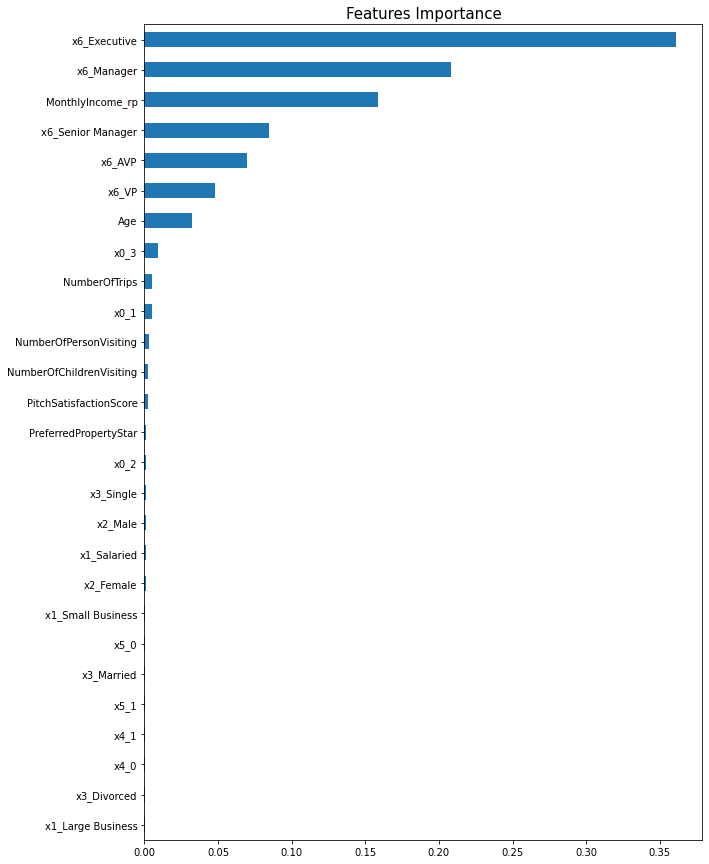

In [35]:
# visualisasi features importance menggunakan bar plot horizontal
importance_table['imp'].sort_values().plot(kind = 'barh', figsize = (10,15))
plt.title('Features Importance', size = 15)
plt.show()

Dari hasil features importances diatas kita dapat melihat fitur-fitur apa saja yang paling penting dalam menentukan label. Penentuan fitur yang akan dipilih adalah fitur dengan nilai importance diatas 3% yaitu sebagai berikut:
1. Seluruh value kolom `Designation` (x6) --> No. Index ke-20, 21, 22, 23, dan 24
2. Kolom `MonthlyIncome_rp` --> No. Index ke-4
3. Kolom `Age` --> No. Index ke-0  
  
No. Index sisanya akan di drop karena fitur-fitur tersebut memiliki bobot yang terlalu kecil dalam menentukan label.

In [36]:
# urutan nomor index fitur dari 0 - 26
X_train_final_df.columns

Index(['Age', 'NumberOfPersonVisiting', 'NumberOfTrips',
       'NumberOfChildrenVisiting', 'MonthlyIncome_rp', 'x0_1', 'x0_2', 'x0_3',
       'x1_Large Business', 'x1_Salaried', 'x1_Small Business', 'x2_Female',
       'x2_Male', 'x3_Divorced', 'x3_Married', 'x3_Single', 'x4_0', 'x4_1',
       'x5_0', 'x5_1', 'x6_AVP', 'x6_Executive', 'x6_Manager',
       'x6_Senior Manager', 'x6_VP', 'PreferredPropertyStar',
       'PitchSatisfactionScore'],
      dtype='object')

In [37]:
# list nomor index yang akan di drop berdasarkan features importance
feat_imp_drop = [1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,25,26]

In [38]:
# ukuran dimensi kolom data sebelum dilakukan drop features
X_train_final.shape[1]

27

In [39]:
# drop kolom berdasarkan features importances
X_train_final = np.delete(X_train_final, np.s_[feat_imp_drop], axis=1)
X_test_final = np.delete(X_test_final, np.s_[feat_imp_drop], axis=1)

In [40]:
# ukuran dimensi kolom data setelah dilakukan drop features
X_train_final.shape[1]

7

In [41]:
# convert ke dataframe
X_train_final_df2 = pd.DataFrame(X_train_final, columns = ['Age', 'MonthlyIncome_rp', 'x6_AVP', 'x6_Executive', 'x6_Manager', 'x6_Senior Manager', 'x6_VP'])
X_train_final_df2.head(10)

,Age,MonthlyIncome_rp,x6_AVP,x6_Executive,x6_Manager,x6_Senior Manager,x6_VP
0,-0.076923,0.058350,0.0,0.0,1.0,0.0,0.0
1,1.846154,0.701264,0.0,0.0,0.0,1.0,0.0
2,0.384615,-1.629211,0.0,0.0,1.0,0.0,0.0
3,-0.615385,-0.142870,0.0,1.0,0.0,0.0,0.0
4,0.000000,-0.046680,0.0,0.0,1.0,0.0,0.0
5,-0.384615,0.372027,0.0,0.0,1.0,0.0,0.0
6,-0.769231,-0.357705,0.0,0.0,1.0,0.0,0.0
7,-0.153846,-0.057113,0.0,1.0,0.0,0.0,0.0
8,1.000000,0.100610,0.0,0.0,1.0,0.0,0.0
9,0.769231,0.666608,0.0,0.0,0.0,1.0,0.0


Features selection bagian 2 telah berhasil dilakukan. Kita telah menghapus fitur yang tidak terlalu berpengaruh dalam menentukan label berdasarkan features importance random forest. Jumlah fitur yang akan digunakan untuk modeling adalah sebanyak 7 fitur.

---
# VI. Model Definition

## Base Model

Pada base model ini, seluruh model akan menggunakan parameter default, lalu selanjutnya akan dipilih 1 model terbaik dari seluruh model yang digunakan. Model machine learning klasifikasi yang akan kita digunakan adalah seluruh model klasifikasi seperti Logistic Regression, Support Vector Machine, Random Forest, K-Nearest Neighbors, Ada Boosting, dan Gradient Boosting.
  
Metrics yang akan digunakan dalam menentukan base model terbaik adalah accuracy score dengan metode training model menggunakan Cross Validation stratified k-fold. Cross-validation digunakan karena untuk memperkokoh hasil evaluasi training model yang dilakukan. Cross validation ini memiliki hasil yang lebih kokoh dibandingkan pada saat kita hanya melakukan satu kali proses training model. Pada cross validation ini, kita akan menetapkan foldnya yaitu 5, artinya data akan dibagi menjadi 5 fold dengan masing-masing fold akan mendapatkan bagiannya menjadi data validasi. Stratified k-fold dipilih untuk menghindari adanya imbalance class pada salah satu fold.

In [42]:
# model Logistic Regression
logreg = LogisticRegression(random_state=10)

# model Support Vector Machine
svc = SVC(random_state=10)

# model Random Forest
ranfor = RandomForestClassifier(random_state=10)

# model K-Nearest Neighbors
knn = KNeighborsClassifier()

# model Ada Boosting
ada = AdaBoostClassifier(random_state=10)

# model Gradient Boosting
gradient_boost = GradientBoostingClassifier(random_state=10)

---
# VII. Model Training

Seperti yang telah dijelaskan sebelumnya, training model akan menggunakan metode cross-validation, stratified k-fold (5 fold). Berikut adalah training modelnya:

In [43]:
# cross-val method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# fit model Logistic Regression
scores_logreg = cross_val_score(logreg, X_train_final, y_train, cv=skf, scoring='accuracy')
print('Cross-Validation Scores Logistic Regression:\n', scores_logreg, '\n')

# fit model SVM
scores_svc = cross_val_score(svc, X_train_final, y_train, cv=skf, scoring='accuracy')
print('Cross-Validation Scores SVM:\n', scores_svc, '\n')

# fit model Random Forest
scores_ranfor = cross_val_score(ranfor, X_train_final, y_train, cv=skf, scoring='accuracy')
print('Cross-Validation Scores Random Forest:\n', scores_ranfor, '\n')

# fit model KNN
scores_knn = cross_val_score(knn, X_train_final, y_train, cv=skf, scoring='accuracy')
print('Cross-Validation Scores KNN:\n', scores_knn, '\n')

# fit model Ada Boosting
scores_ada = cross_val_score(ada, X_train_final, y_train, cv=skf, scoring='accuracy')
print('Cross-Validation Scores Ada Boosting:\n', scores_ada, '\n')

# fit model Gradient Boosting
scores_gradient_boost = cross_val_score(gradient_boost, X_train_final, y_train, cv=skf, scoring='accuracy')
print('Cross-Validation Scores Gradient Boosting:\n', scores_gradient_boost)

Cross-Validation Scores Logistic Regression:
 [1.        0.9987163 1.        1.        1.       ] 

Cross-Validation Scores SVM:
 [1.        0.9987163 1.        1.        1.       ] 

Cross-Validation Scores Random Forest:
 [1. 1. 1. 1. 1.] 

Cross-Validation Scores KNN:
 [0.9987163 0.9987163 0.9987163 1.        1.       ] 

Cross-Validation Scores Ada Boosting:
 [1. 1. 1. 1. 1.] 

Cross-Validation Scores Gradient Boosting:
 [1. 1. 1. 1. 1.]


Hasil diatas adalah hasil cross-validation dengan melakukan 5 kali modeling menggunakan 5 fold data pada setiap modelnya. Hasil yang didapatkan cukup beragam, untuk dapat melihat hasil akhirnya dan menentukan model terbaik, saya akan menggunakan fungsi mean dan standar deviasi untuk melihat hasil akurasi skor pada masing-masing model.

In [44]:
# mean dan standar deviasi scores model logistic regression
print('Cross-Validation Mean Scores Logistic Regression\t\t:', scores_logreg.mean(), 
      '\nCross-Validation Standard Deviation Scores Logistic Regression\t:', scores_logreg.std(), '\n')

# mean dan standar deviasi scores model SVM
print('Cross-Validation Mean Scores SVM\t\t\t\t:', scores_svc.mean(),
      '\nCross-Validation Standard Deviation Scores SVM\t\t\t:', scores_svc.std(), '\n')

# mean dan standar deviasi scores model Random Forest
print('Cross-Validation Mean Scores Random Forest\t\t\t:', scores_ranfor.mean(),
      '\nCross-Validation Standard Deviation Scores Random Forest\t:', scores_ranfor.std(), '\n')

# mean dan standar deviasi scores model KNN
print('Cross-Validation Mean Scores KNN\t\t\t\t:', scores_knn.mean(),
      '\nCross-Validation Standard Deviation Scores KNN\t\t\t:', scores_knn.std(), '\n')

# mean dan standar deviasi scores model Ada Boosting
print('Cross-Validation Mean Scores Ada Boosting\t\t\t:', scores_ada.mean(),
      '\nCross-Validation Standard Deviation Scores Ada Boosting\t\t:', scores_ada.std(), '\n')

# mean dan standar deviasi scores model Gradient Boosting
print('Cross-Validation Mean Scores Gradient Boosting\t\t\t:', scores_gradient_boost.mean(),
      '\nCross-Validation Standard Deviation Scores Gradient Boosting\t:', scores_gradient_boost.std())

Cross-Validation Mean Scores Logistic Regression		: 0.9997432605905006 
Cross-Validation Standard Deviation Scores Logistic Regression	: 0.0005134788189987028 

Cross-Validation Mean Scores SVM				: 0.9997432605905006 
Cross-Validation Standard Deviation Scores SVM			: 0.0005134788189987028 

Cross-Validation Mean Scores Random Forest			: 1.0 
Cross-Validation Standard Deviation Scores Random Forest	: 0.0 

Cross-Validation Mean Scores KNN				: 0.999229781771502 
Cross-Validation Standard Deviation Scores KNN			: 0.0006288805501368712 

Cross-Validation Mean Scores Ada Boosting			: 1.0 
Cross-Validation Standard Deviation Scores Ada Boosting		: 0.0 

Cross-Validation Mean Scores Gradient Boosting			: 1.0 
Cross-Validation Standard Deviation Scores Gradient Boosting	: 0.0


Dari hasil cross-validation diatas, kita dapat melihat bahwa hampir seluruh model memiliki akurasi skor yang sempurna. Model Random Forest, Ada Boosting, dan Gradient Boosting menghasilkan skor akurasi yang sempurna 100%, namun kita perlu memperhatikan adanya kemungkinan model ini mengalami overfitting. Untuk itu kita perlu menguji model ini lebih lanjut pada data test-set.  
  
Untuk menentukan model terbaik diantara ketiga model yang menghasilkan nilai akurasi sempurna, kita akan memilihnya berdasarkan waktu tercepat pada proses training model. Model yang memiliki proses klasifikasi yang cepat akan memberikan pengalaman user input yang lebih baik daripada model dengan proses yang lebih lama, sehingga waktu pemrosesan model dapat kita jadikan sebagai parameter dalam menentukan model terbaik. Jika kita running code diatas saat cross-validation, terlihat bahwa model Ada Boosting sedikit lebih cepat daripada model Random Forest, sedangkan model Gradient Boosting merupakan model yang paling lama pada proses training model. Sehingga penentuan model terbaik dari hasil diatas adalah model Ada Boosting.
> **Model Terbaik -> Ada Boosting**

---
# VIII. Model Evaluation

Pada bagian model evaluation ini, kita akan melihat performa model ada boost pada data test-set. Jika hasil performanya menunjukan akurasi yang buruk, maka dapat dipastikan bahwa model ada boost ini mengalami overfitting, namun jika hasil performanya pada data test-set menunjukan hasil sempurna, artinya model ada boost ini merupakan model best fit pada dataset ini.

In [45]:
# model ada boosting fit pada data train-set
ada.fit(X_train_final, y_train)

# model predict pada train-set dan test-set
y_pred_train = ada.predict(X_train_final)
y_pred_test = ada.predict(X_test_final)

# hasil klasifikasi report model ada boosting
print('Classification Report Model Ada Boosting pada Train-set:\n', classification_report(y_train, y_pred_train))
print('Classification Report Model Ada Boosting pada Test-set\n', classification_report(y_test, y_pred_test))

Classification Report Model Ada Boosting pada Train-set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1475
           1       1.00      1.00      1.00      1960
           2       1.00      1.00      1.00       459

    accuracy                           1.00      3894
   macro avg       1.00      1.00      1.00      3894
weighted avg       1.00      1.00      1.00      3894

Classification Report Model Ada Boosting pada Test-set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       506
           2       1.00      1.00      1.00       109

    accuracy                           1.00       974
   macro avg       1.00      1.00      1.00       974
weighted avg       1.00      1.00      1.00       974



Hasil akurasi skor pada data test-set menunjukan hasil yang sempurna yaitu 100%, artinya model ini tidak mengalami overfitting, sehingga kita dapat menggunakan model ada boost ini dalam melakukan klasifikasi user baru berdasarkan karakteristik masing-masing user tersebut. Hasil performa model yang sempurna ini dapat terjadi karena adanya kemungkinan pada label `ProductPitched` yang sangat bergantung pada beberapa fitur, sehingga hasil performanya menunjukan hasil yang sempurna. Perlu dijadikan sebagai catatan bahwa fokus utama dataset ini awalnya berfokus pada kolom `ProdTaken` sebagai labelnya, namun karena objective project ini ingin berfokus pada kolom `ProductPitched`, maka hasil model evaluasi yang sempurna ini dapat terjadi secara kebetulan.

---
# IX. Model Inference

Pada model inference ini kita akan mencoba mengaplikasikan model klasifikasi yang sudah kita buat sebelumnya untuk memprediksi kelas user tersebut berdasarkan karakteristiknya.

In [46]:
# preview data inference
df_inf

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,MonthlyIncome_rp
0,203216,Not_taken,57.0,Company Invited,1,16.0,Small Business,Female,4,4.0,Basic,3.0,Divorced,4.0,0,2,0,1.0,Executive,21620.0,4100881.60
1,203961,Not_taken,38.0,Self Enquiry,1,26.0,Salaried,Male,4,4.0,Basic,4.0,Married,6.0,0,4,0,2.0,Executive,21700.0,4116056.00
2,201750,Not_taken,53.0,Self Enquiry,1,9.0,Small Business,Male,2,3.0,Super Deluxe,3.0,Married,4.0,1,5,1,0.0,AVP,32584.0,6180533.12
3,202979,Not_taken,42.0,Self Enquiry,2,17.0,Salaried,Male,4,5.0,King,3.0,Married,0.0,0,2,1,1.0,VP,37819.0,7173507.92
4,202727,Not_taken,56.0,Self Enquiry,1,27.0,Large Business,Male,3,4.0,Deluxe,3.0,Divorced,5.0,1,2,1,2.0,Manager,24093.0,4569960.24
5,202136,Taken,45.0,Self Enquiry,1,9.0,Salaried,Female,2,3.0,Deluxe,3.0,Married,1.0,1,5,1,1.0,Manager,35421.0,6718655.28
6,202766,Not_taken,33.0,Self Enquiry,1,9.0,Small Business,Female,4,3.0,Deluxe,3.0,Unmarried,2.0,0,3,1,3.0,Manager,23733.0,4501675.44
7,204143,Taken,30.0,Self Enquiry,1,25.0,Small Business,Male,3,5.0,Basic,3.0,Single,3.0,1,3,0,1.0,Executive,21067.0,3995988.56
8,200977,Not_taken,34.0,Company Invited,1,32.0,Large Business,Female,3,4.0,Basic,3.0,Married,2.0,0,1,1,0.0,Executive,17029.0,3230060.72
9,200608,Taken,55.0,Self Enquiry,3,8.0,Small Business,Male,2,3.0,Deluxe,3.0,Single,5.0,0,2,0,1.0,Manager,20160.0,3823948.80


Sebelum melakukan model inference, kita perlu melakukan tahapan data preprocessing agar data inference siap untuk diprediksi oleh model. Proses data preprocessing akan melakukan proses yang sama seperti data preprocessing pada train-set dan test-set sebelumnya.

## Preprocessing Data Inference

In [47]:
# split label dan fitur
X_inf = df_inf.drop(['CustomerID', 'ProductPitched', 'ProdTaken', 'TypeofContact','NumberOfFollowups', 'DurationOfPitch', 'MonthlyIncome'], axis = 1)
y_inf = df_inf['ProductPitched'].map({'Basic': 0, 'Deluxe': 1, 'Standard': 1, 'Super Deluxe': 2, 'King' : 2})

In [48]:
# menggabungkan beberapa value kategori
X_inf['MaritalStatus'] = X_inf['MaritalStatus'].replace('Unmarried', 'Single')
X_inf['Occupation'] = X_inf['Occupation'].replace('Free Lancer', 'Salaried')

In [49]:
# scaling dan encodind data inference menggunakan pipeline
X_inf_final = pipeline_pre.transform(X_inf)

In [50]:
# convert ke dataframe
X_inf_final_df = pd.DataFrame(X_inf_final, columns = num_cols + ohe_features + cat_cols_ord)
X_inf_final_df.head(10)

,Age,NumberOfPersonVisiting,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome_rp,x0_1,x0_2,x0_3,x1_Large Business,x1_Salaried,x1_Small Business,x2_Female,x2_Male,x3_Divorced,x3_Married,x3_Single,x4_0,x4_1,x5_0,x5_1,x6_AVP,x6_Executive,x6_Manager,x6_Senior Manager,x6_VP,PreferredPropertyStar,PitchSatisfactionScore
0,1.615385,1.0,0.5,0.0,-0.128901,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.153846,1.0,1.5,1.0,-0.114756,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0
2,1.307692,-1.0,0.5,-1.0,1.809743,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.461538,1.0,-1.5,0.0,2.735390,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.538462,0.0,1.0,1.0,0.308372,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.692308,-1.0,-1.0,0.0,2.311378,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
6,-0.230769,1.0,-0.5,2.0,0.244718,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
7,-0.461538,0.0,0.0,0.0,-0.226682,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
8,-0.153846,0.0,-0.5,-1.0,-0.940677,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,1.461538,-1.0,1.0,0.0,-0.387057,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [51]:
# drop kolom berdasarkan features importances
X_inf_final = np.delete(X_inf_final, np.s_[feat_imp_drop], axis=1)

## Model Predict Data Inference

Setelah data inference telah melalui tahap preprocessing, selanjutnya model akan memprediksi kelas user pada data inference.

In [52]:
# model predict pada data inference
y_pred_inf = ada.predict(X_inf_final)
y_pred_inf

array([0, 0, 2, 2, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 1],
      dtype=int64)

In [53]:
# convert hasil predict model ke dataframe
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns = ['UserClass_Prediction'])
y_pred_inf_df

,UserClass_Prediction
0,0
1,0
2,2
3,2
4,1
5,1
6,1
7,0
8,0
9,1


In [54]:
# Merge dataframe inference dengan prediksi model
pd.concat([df_inf, y_pred_inf_df], axis = 1)

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,MonthlyIncome_rp,UserClass_Prediction
0,203216,Not_taken,57.0,Company Invited,1,16.0,Small Business,Female,4,4.0,Basic,3.0,Divorced,4.0,0,2,0,1.0,Executive,21620.0,4100881.60,0
1,203961,Not_taken,38.0,Self Enquiry,1,26.0,Salaried,Male,4,4.0,Basic,4.0,Married,6.0,0,4,0,2.0,Executive,21700.0,4116056.00,0
2,201750,Not_taken,53.0,Self Enquiry,1,9.0,Small Business,Male,2,3.0,Super Deluxe,3.0,Married,4.0,1,5,1,0.0,AVP,32584.0,6180533.12,2
3,202979,Not_taken,42.0,Self Enquiry,2,17.0,Salaried,Male,4,5.0,King,3.0,Married,0.0,0,2,1,1.0,VP,37819.0,7173507.92,2
4,202727,Not_taken,56.0,Self Enquiry,1,27.0,Large Business,Male,3,4.0,Deluxe,3.0,Divorced,5.0,1,2,1,2.0,Manager,24093.0,4569960.24,1
5,202136,Taken,45.0,Self Enquiry,1,9.0,Salaried,Female,2,3.0,Deluxe,3.0,Married,1.0,1,5,1,1.0,Manager,35421.0,6718655.28,1
6,202766,Not_taken,33.0,Self Enquiry,1,9.0,Small Business,Female,4,3.0,Deluxe,3.0,Unmarried,2.0,0,3,1,3.0,Manager,23733.0,4501675.44,1
7,204143,Taken,30.0,Self Enquiry,1,25.0,Small Business,Male,3,5.0,Basic,3.0,Single,3.0,1,3,0,1.0,Executive,21067.0,3995988.56,0
8,200977,Not_taken,34.0,Company Invited,1,32.0,Large Business,Female,3,4.0,Basic,3.0,Married,2.0,0,1,1,0.0,Executive,17029.0,3230060.72,0
9,200608,Taken,55.0,Self Enquiry,3,8.0,Small Business,Male,2,3.0,Deluxe,3.0,Single,5.0,0,2,0,1.0,Manager,20160.0,3823948.80,1


In [55]:
# Perbandingan prediksi model dengan data sesungguhnya
pd.concat([y_inf, y_pred_inf_df], axis = 1)

,ProductPitched,UserClass_Prediction
0,0,0
1,0,0
2,2,2
3,2,2
4,1,1
5,1,1
6,1,1
7,0,0
8,0,0
9,1,1


In [56]:
# hasil akurasi model gradient boosting pada data inference
print('Classification Report Model Ada Boosting Pada Data Inference\n', classification_report(y_inf, y_pred_inf))

Classification Report Model Ada Boosting Pada Data Inference
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Kesimpulan dari model inference ini adalah model Ada Boosting dapat memprediksi data inference dengan akurasi skor 100%. Model ini dapat memprediksi kelas user secara tepat tanpa memiliki error satupun. Model klasifikasi ini akan digunakan sebagai model pertama dalam project ini dalam menentukan kelas user, dan selanjutnya dari hasil kelas user tersebut, kita akan merekomendasikan destinasi wisata yang sesuai dengan masing-masing kelas user.

---
# X. Model Saving

Model klasifikasi dan pipeline preprocessing akan kita save untuk keperluan model deployment berikutnya.

In [57]:
# saving model ada boosting
with open('model_class.pkl', 'wb') as file_1:
  pickle.dump(ada, file_1)

# saving pipeline preprocessing
with open('pipeline_pre.pkl', 'wb') as file_2:
  pickle.dump(pipeline_pre, file_2)